**Recommendation System**


  A recommendation system, also known as a recommender system, is a subclass of information filtering systems that seeks to predict the "rating" or "preference" a user would give to an item






**Importing Libraries and Loading**

In [1]:
import pandas as pd
import numpy as np
import pickle
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt
import seaborn as sns
import google.generativeai as genai

destination_df = pd.read_csv("/content/Expanded_Destinations.csv")
reviews_df = pd.read_csv("/content/Final_Updated_Expanded_Reviews.csv")
userhistory_df = pd.read_csv("/content/Final_Updated_Expanded_UserHistory.csv")
users_df = pd.read_csv("/content/Final_Updated_Expanded_Users.csv")


/usr/local/lib/python3.12/dist-packages/google/colab/_import_hooks/_hook_injector.py:55: FutureWarning: 

All support for the `google.generativeai` package has ended. It will no longer be receiving 
updates or bug fixes. Please switch to the `google.genai` package as soon as possible.
See README for more details:

https://github.com/google-gemini/deprecated-generative-ai-python/blob/main/README.md

  loader.exec_module(module)


In [2]:
destination_df.head(5)

,DestinationID,Name,State,Type,Popularity,BestTimeToVisit
0,1,Taj Mahal,Uttar Pradesh,Historical,8.691906,Nov-Feb
1,2,Goa Beaches,Goa,Beach,8.605032,Nov-Mar
2,3,Jaipur City,Rajasthan,City,9.225372,Oct-Mar
3,4,Kerala Backwaters,Kerala,Nature,7.977386,Sep-Mar
4,5,Leh Ladakh,Jammu and Kashmir,Adventure,8.399822,Apr-Jun


In [3]:
reviews_df.head(5)

,ReviewID,DestinationID,UserID,Rating,ReviewText
0,1,178,327,2,Incredible monument!
1,2,411,783,1,Loved the beaches!
2,3,927,12,2,A historical wonder
3,4,358,959,3,Incredible monument!
4,5,989,353,2,Loved the beaches!


In [4]:
userhistory_df.head(5)

,HistoryID,UserID,DestinationID,VisitDate,ExperienceRating
0,1,525,760,2024-01-01,3
1,2,184,532,2024-02-15,5
2,3,897,786,2024-03-20,2
3,4,470,660,2024-01-01,1
4,5,989,389,2024-02-15,4


In [5]:
users_df.head(5)

,UserID,Name,Email,Preferences,Gender,NumberOfAdults,NumberOfChildren
0,1,Kavya,kavya@example.com,"Beaches, Historical",Female,1,0
1,2,Rohan,rohan@example.com,"Nature, Adventure",Male,2,2
2,3,Kavya,kavya@example.com,"City, Historical",Female,2,0
3,4,Anika,anika@example.com,"Beaches, Historical",Female,1,0
4,5,Tanvi,tanvi@example.com,"Nature, Adventure",Female,2,2


**Data Preprocessing**


In [8]:
destination_df_unique = destination_df.drop_duplicates(subset=['Name']).reset_index(drop=True)

In [9]:
reviews_destinations = pd.merge(reviews_df,destination_df,on='DestinationID',how='inner')
reviews_destinations.head()

,ReviewID,DestinationID,UserID,Rating,ReviewText,Name,State,Type,Popularity,BestTimeToVisit
0,1,178,327,2,Incredible monument!,Jaipur City,Rajasthan,City,8.544352,Oct-Mar
1,2,411,783,1,Loved the beaches!,Taj Mahal,Uttar Pradesh,Historical,8.284127,Nov-Feb
2,3,927,12,2,A historical wonder,Goa Beaches,Goa,Beach,7.741214,Nov-Mar
3,4,358,959,3,Incredible monument!,Jaipur City,Rajasthan,City,7.738761,Oct-Mar
4,5,989,353,2,Loved the beaches!,Kerala Backwaters,Kerala,Nature,8.208088,Sep-Mar


In [10]:
reviews_destination_userhistory = pd.merge(reviews_destinations,userhistory_df,on='UserID',how='inner')
reviews_destination_userhistory.head(5)

,ReviewID,DestinationID_x,UserID,Rating,ReviewText,Name,State,Type,Popularity,BestTimeToVisit,HistoryID,DestinationID_y,VisitDate,ExperienceRating
0,1,178,327,2,Incredible monument!,Jaipur City,Rajasthan,City,8.544352,Oct-Mar,79,175,2024-01-01,3
1,2,411,783,1,Loved the beaches!,Taj Mahal,Uttar Pradesh,Historical,8.284127,Nov-Feb,834,894,2024-03-20,2
2,4,358,959,3,Incredible monument!,Jaipur City,Rajasthan,City,7.738761,Oct-Mar,998,660,2024-02-15,4
3,5,989,353,2,Loved the beaches!,Kerala Backwaters,Kerala,Nature,8.208088,Sep-Mar,202,894,2024-01-01,5
4,6,473,408,4,A historical wonder,Jaipur City,Rajasthan,City,8.138558,Oct-Mar,331,403,2024-01-01,2


In [11]:
df = pd.merge(reviews_destination_userhistory,users_df,on='UserID',how='inner')
df

,ReviewID,DestinationID_x,UserID,Rating,ReviewText,Name_x,State,Type,Popularity,BestTimeToVisit,HistoryID,DestinationID_y,VisitDate,ExperienceRating,Name_y,Email,Preferences,Gender,NumberOfAdults,NumberOfChildren
0,1,178,327,2,Incredible monument!,Jaipur City,Rajasthan,City,8.544352,Oct-Mar,79,175,2024-01-01,3,Pooja,pooja@example.com,"City, Historical",Female,1,1
1,2,411,783,1,Loved the beaches!,Taj Mahal,Uttar Pradesh,Historical,8.284127,Nov-Feb,834,894,2024-03-20,2,Karan,karan@example.com,"City, Historical",Male,1,1
2,4,358,959,3,Incredible monument!,Jaipur City,Rajasthan,City,7.738761,Oct-Mar,998,660,2024-02-15,4,Ritvik,ritvik@example.com,"Nature, Adventure",Male,1,1
3,5,989,353,2,Loved the beaches!,Kerala Backwaters,Kerala,Nature,8.208088,Sep-Mar,202,894,2024-01-01,5,Isha,isha@example.com,"Nature, Adventure",Female,2,0
4,6,473,408,4,A historical wonder,Jaipur City,Rajasthan,City,8.138558,Oct-Mar,331,403,2024-01-01,2,Ishaan,ishaan@example.com,"City, Historical",Male,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
988,991,701,850,3,Incredible monument!,Taj Mahal,Uttar Pradesh,Historical,8.814029,Nov-Feb,138,131,2024-03-20,1,Hitesh,hitesh@example.com,"Beaches, Historical",Male,2,0
989,991,701,850,3,Incredible monument!,Taj Mahal,Uttar Pradesh,Historical,8.814029,Nov-Feb,643,761,2024-01-01,4,Hitesh,hitesh@example.com,"Beaches, Historical",Male,2,0
990,995,231,346,5,Loved the beaches!,Taj Mahal,Uttar Pradesh,Historical,7.788256,Nov-Feb,454,113,2024-01-01,2,Hitesh,hitesh@example.com,"Beaches, Historical",Male,2,2
991,995,231,346,5,Loved the beaches!,Taj Mahal,Uttar Pradesh,Historical,7.788256,Nov-Feb,556,128,2024-01-01,4,Hitesh,hitesh@example.com,"Beaches, Historical",Male,2,2


In [12]:
df.shape

(993, 20)

In [13]:
df.duplicated().sum()

np.int64(0)

In [14]:
df.isnull().sum()

,0
ReviewID,0
DestinationID_x,0
UserID,0
Rating,0
ReviewText,0
Name_x,0
State,0
Type,0
Popularity,0
BestTimeToVisit,0


**Visualization**

/tmp/ipython-input-3686794349.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Popularity',y='Name',data=destination_df.sort_values(by='Popularity',ascending=False),palette='viridis')


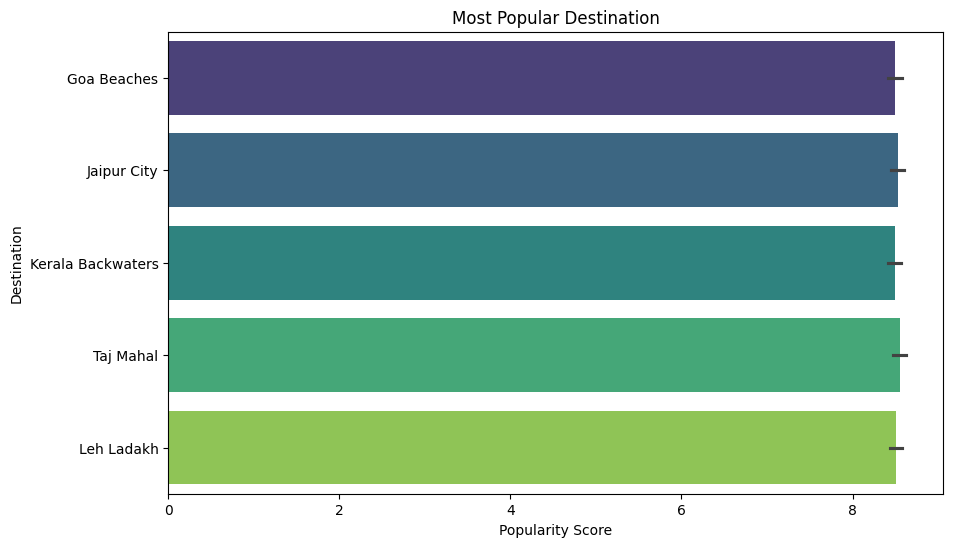

In [15]:
#1. Destination Popularity
plt.figure(figsize=(10,6))
sns.barplot(x='Popularity',y='Name',data=destination_df.sort_values(by='Popularity',ascending=False),palette='viridis')
plt.title("Most Popular Destination")
plt.xlabel("Popularity Score")
plt.ylabel("Destination")
plt.show()

In [16]:
destination_df['Type'].value_counts() #to see the frequency of every type of destination

,count
Type,
Historical,200
Beach,200
City,200
Nature,200
Adventure,200


/tmp/ipython-input-1744554881.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='Type',data=destination_df,order=destination_df['Type'].value_counts().index,palette='coolwarm')


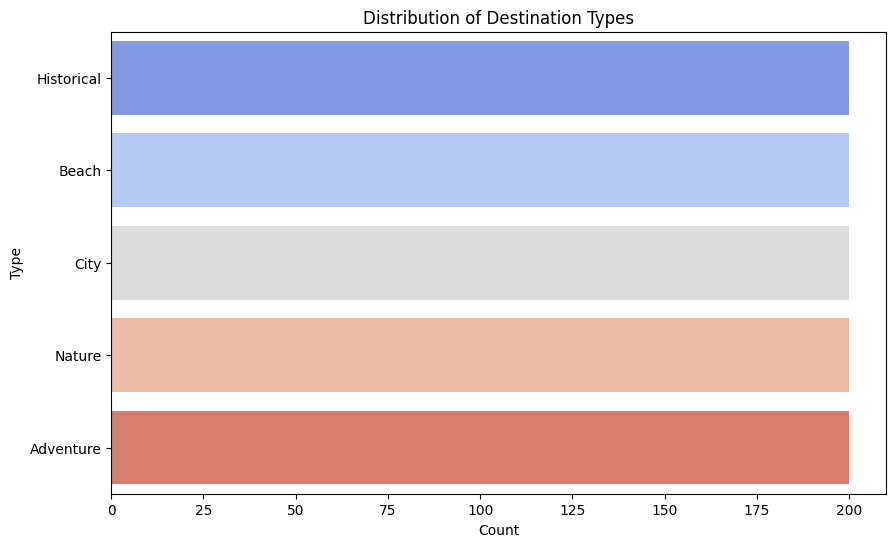

In [17]:
#2. Destination Types Distribution
plt.figure(figsize=(10,6))
#countplot shows distribution/count
sns.countplot(y='Type',data=destination_df,order=destination_df['Type'].value_counts().index,palette='coolwarm')
plt.title('Distribution of Destination Types')
plt.xlabel('Count')
plt.ylabel('Type')
plt.show()

/tmp/ipython-input-999543745.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='BestTimeToVisit',data=destination_df,order=destination_df['BestTimeToVisit'].value_counts().index,palette='rocket')


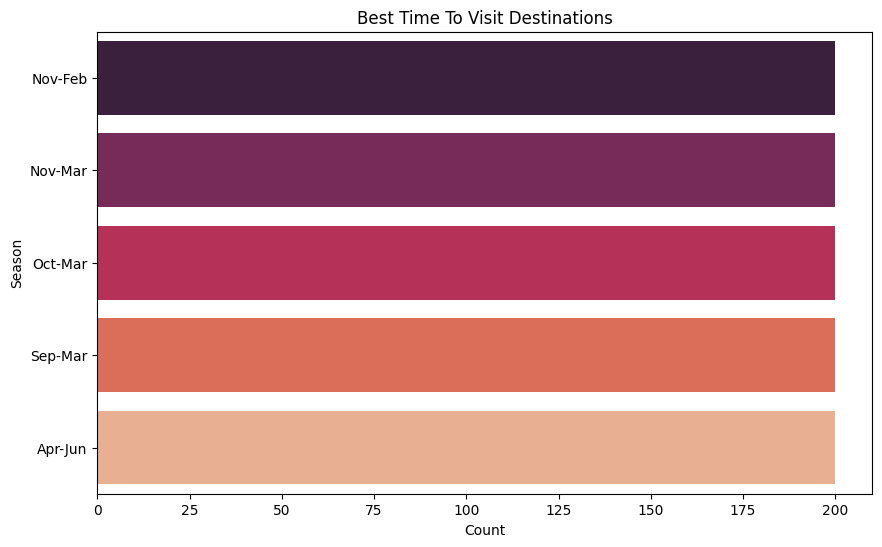

In [18]:
#3. Best time to Visit Distribution
plt.figure(figsize=(10,6))
sns.countplot(y='BestTimeToVisit',data=destination_df,order=destination_df['BestTimeToVisit'].value_counts().index,palette='rocket')
plt.title('Best Time To Visit Destinations')
plt.xlabel('Count')
plt.ylabel('Season')
plt.show()

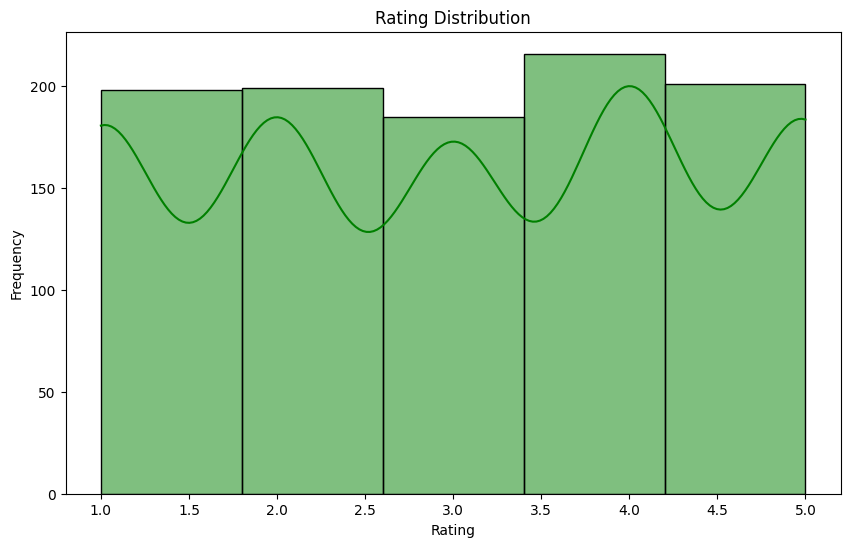

In [19]:
#4. Rating Distribution
plt.figure(figsize=(10,6))
sns.histplot(reviews_df['Rating'],bins=5,kde=True,color='green')
plt.title('Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

In [20]:
df

,ReviewID,DestinationID_x,UserID,Rating,ReviewText,Name_x,State,Type,Popularity,BestTimeToVisit,HistoryID,DestinationID_y,VisitDate,ExperienceRating,Name_y,Email,Preferences,Gender,NumberOfAdults,NumberOfChildren
0,1,178,327,2,Incredible monument!,Jaipur City,Rajasthan,City,8.544352,Oct-Mar,79,175,2024-01-01,3,Pooja,pooja@example.com,"City, Historical",Female,1,1
1,2,411,783,1,Loved the beaches!,Taj Mahal,Uttar Pradesh,Historical,8.284127,Nov-Feb,834,894,2024-03-20,2,Karan,karan@example.com,"City, Historical",Male,1,1
2,4,358,959,3,Incredible monument!,Jaipur City,Rajasthan,City,7.738761,Oct-Mar,998,660,2024-02-15,4,Ritvik,ritvik@example.com,"Nature, Adventure",Male,1,1
3,5,989,353,2,Loved the beaches!,Kerala Backwaters,Kerala,Nature,8.208088,Sep-Mar,202,894,2024-01-01,5,Isha,isha@example.com,"Nature, Adventure",Female,2,0
4,6,473,408,4,A historical wonder,Jaipur City,Rajasthan,City,8.138558,Oct-Mar,331,403,2024-01-01,2,Ishaan,ishaan@example.com,"City, Historical",Male,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
988,991,701,850,3,Incredible monument!,Taj Mahal,Uttar Pradesh,Historical,8.814029,Nov-Feb,138,131,2024-03-20,1,Hitesh,hitesh@example.com,"Beaches, Historical",Male,2,0
989,991,701,850,3,Incredible monument!,Taj Mahal,Uttar Pradesh,Historical,8.814029,Nov-Feb,643,761,2024-01-01,4,Hitesh,hitesh@example.com,"Beaches, Historical",Male,2,0
990,995,231,346,5,Loved the beaches!,Taj Mahal,Uttar Pradesh,Historical,7.788256,Nov-Feb,454,113,2024-01-01,2,Hitesh,hitesh@example.com,"Beaches, Historical",Male,2,2
991,995,231,346,5,Loved the beaches!,Taj Mahal,Uttar Pradesh,Historical,7.788256,Nov-Feb,556,128,2024-01-01,4,Hitesh,hitesh@example.com,"Beaches, Historical",Male,2,2


In [21]:
from sentence_transformers import SentenceTransformer
# --- STEP 2: WORD EMBEDDINGS
# We use SBERT to turn text into meaningful 384-dimensional vectors
print("Generating Word Embeddings...")
embed_model = SentenceTransformer('all-MiniLM-L6-v2')

# Create text features for destinations
destination_df['combined_text'] = (
    destination_df['Type'] + " " +
    destination_df['State'] + " " +
    destination_df['BestTimeToVisit']
)

Generating Word Embeddings...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [22]:
destination_df

,DestinationID,Name,State,Type,Popularity,BestTimeToVisit,combined_text
0,1,Taj Mahal,Uttar Pradesh,Historical,8.691906,Nov-Feb,Historical Uttar Pradesh Nov-Feb
1,2,Goa Beaches,Goa,Beach,8.605032,Nov-Mar,Beach Goa Nov-Mar
2,3,Jaipur City,Rajasthan,City,9.225372,Oct-Mar,City Rajasthan Oct-Mar
3,4,Kerala Backwaters,Kerala,Nature,7.977386,Sep-Mar,Nature Kerala Sep-Mar
4,5,Leh Ladakh,Jammu and Kashmir,Adventure,8.399822,Apr-Jun,Adventure Jammu and Kashmir Apr-Jun
...,...,...,...,...,...,...,...
995,996,Taj Mahal,Uttar Pradesh,Historical,8.133818,Nov-Feb,Historical Uttar Pradesh Nov-Feb
996,997,Goa Beaches,Goa,Beach,8.203519,Nov-Mar,Beach Goa Nov-Mar
997,998,Jaipur City,Rajasthan,City,8.308435,Oct-Mar,City Rajasthan Oct-Mar
998,999,Kerala Backwaters,Kerala,Nature,8.961741,Sep-Mar,Nature Kerala Sep-Mar


In [23]:
# Encode all destinations into a vector space
dest_embeddings = embed_model.encode(destination_df['combined_text'].tolist())

In [24]:
# --- STEP 3: ROBUST ORDINAL ENCODING
features = ['State', 'Type', 'Gender', 'NumberOfAdults', 'NumberOfChildren']
categorical_cols = ['State', 'Type', 'Gender']

In [ ]:
# 'handle_unknown' prevents the system from crashing on new inputs
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

X = df[features].copy()
X[categorical_cols] = encoder.fit_transform(X[categorical_cols])
y = df['ExperienceRating']

# Train the Popularity Predictor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X, y)

RandomForestRegressor(random_state=42)

In [ ]:
# 1. Load and CLEAN data (Crucial step to remove duplicates from source)
destination_df_unique = destination_df.drop_duplicates(subset=['Name']).reset_index(drop=True)

In [ ]:
# 2. Re-generate Embeddings on the clean list
embed_model = SentenceTransformer('all-MiniLM-L6-v2')
destination_df['combined_text'] = (
    destination_df['Type'] + " " +
    destination_df['State'] + " " +
    destination_df['BestTimeToVisit']
    )
dest_embeddings = embed_model.encode(destination_df['combined_text'].tolist())

In [ ]:
# 2. Re-embed the unique list
embed_model = SentenceTransformer('all-MiniLM-L6-v2')
dest_embeddings = embed_model.encode(destination_df_unique['combined_text'].tolist())

In [ ]:
def get_top_5_unique(user_query_text, dest_df, embeddings):
    # Convert user query to vector
    user_vec = embed_model.encode([user_query_text])

    # Calculate similarities across ALL unique destinations
    sim_scores = cosine_similarity(user_vec, embeddings)[0]

    # Get indices of the top 10 matches (just in case there are still slight name variations)
    top_indices = np.argsort(sim_scores)[::-1][:10]

    results = []
    seen = set()

    for idx in top_indices:
        dest_name = dest_df.iloc[idx]['Name']

        # Uniqueness check
        if dest_name not in seen:
            results.append(dest_df.iloc[idx])
            seen.add(dest_name)

        # Stop exactly at 5
        if len(results) == 5:
            break

    return pd.DataFrame(results)

In [ ]:
user_pref = "I want a historical place in Rajasthan with beautiful architecture"
final_recommendations = get_top_5_unique(user_pref, destination_df_unique, dest_embeddings)

print("✅ Your Top 5 Unique Recommendations:")
print(final_recommendations[['Name', 'State', 'Type']])

✅ Your Top 5 Unique Recommendations:
                Name              State        Type
2        Jaipur City          Rajasthan        City
0          Taj Mahal      Uttar Pradesh  Historical
4         Leh Ladakh  Jammu and Kashmir   Adventure
3  Kerala Backwaters             Kerala      Nature
1        Goa Beaches                Goa       Beach


In [ ]:
import pickle
import numpy as np

# 1. Save the Random Forest Model
with open('model.pkl', 'wb') as f:
    pickle.dump(model, f)

# 2. Save the Ordinal Encoder
# (Crucial for transforming new user input in the dashboard)
with open('encoder.pkl', 'wb') as f:
    pickle.dump(encoder, f)

# 3. Save the Destination Embeddings (NumPy format is fastest for this)
np.save('dest_embeddings.npy', dest_embeddings)

print("✅ Dashboard assets saved: model.pkl, encoder.pkl, dest_embeddings.npy")

✅ Dashboard assets saved: model.pkl, encoder.pkl, dest_embeddings.npy


In [ ]:
# LOADING CODE FOR YOUR DASHBOARD
import pickle
import numpy as np
from sentence_transformers import SentenceTransformer

# Load the brain of your system
model = pickle.load(open('model.pkl', 'rb'))
encoder = pickle.load(open('encoder.pkl', 'rb'))
dest_embeddings = np.load('dest_embeddings.npy')

# You will still need to initialize the embedding model to encode the new user's query
embed_model = SentenceTransformer('all-MiniLM-L6-v2')

In [ ]:
import os
import google.generativeai as genai

# Set your key (or set it in your system environment variables)
os.environ["GEMINI_API_KEY"] = "YOUR_ACTUAL_API_KEY_HERE"

genai.configure(api_key=os.environ["GEMINI_API_KEY"])